# 銀行解約データセットを使用した二項分類
# ベースライン作成

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import gc 

# 分布確認  anacondaでは、一先ず、コメントにする。
#import pandas_profiling as pdp

# 可視化
import matplotlib.pyplot as plt

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

# バリデーション
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# 評価指標
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# モデリング: lightgbm
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# matplotilbで日本語表示したい場合はこれをinstallしてインポートする
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline


In [2]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip show lightgbm

Name: lightgbm
Version: 3.3.5
Summary: LightGBM Python Package
Home-page: https://github.com/microsoft/LightGBM
Author: 
Author-email: 
License: The MIT License (Microsoft)
Location: C:\Users\akiyosi honma\anaconda3\Lib\site-packages
Requires: numpy, scikit-learn, scipy, wheel
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip show pandas_profiling

Name: pandas-profiling
Version: 3.2.0
Summary: Generate profile report for pandas DataFrame
Home-page: https://github.com/pandas-profiling/pandas-profiling
Author: Simon Brugman
Author-email: pandasprofiling@gmail.com
License: MIT
Location: C:\Users\akiyosi honma\anaconda3\Lib\site-packages
Requires: htmlmin, jinja2, joblib, markupsafe, matplotlib, missingno, multimethod, numpy, pandas, phik, pydantic, PyYAML, requests, scipy, seaborn, tangled-up-in-unicode, tqdm, visions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


####　ファイルの読み込み

In [6]:
df_train=pd.read_csv("Bank Churn/train.csv")
df_train.head(15)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


# データの確認（簡易）
## レコード数とカラム数の確認

#### レコード数とカラム数の確認

In [7]:
print(df_train.shape)
print("レコード数:",len(df_train))
print("カラム数:",len(df_train.columns))

(165034, 14)
レコード数: 165034
カラム数: 14


##カラムごとのデータの種類の確認

#### データの確認

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


#### データ型の変換(仮の処理)

In [9]:
df_train["Age"]=df_train["Age"].astype(object)
df_train[["Age"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Age     165034 non-null  object
dtypes: object(1)
memory usage: 1.3+ MB


#### データ型をobject型からint型に戻す(仮の処理)

In [10]:
df_train["Age"] = df_train["Age"].astype(np.int64)
df_train[["Age"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   Age     165034 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB


##欠損値の確認
#### 欠損値の確認

In [11]:
df_train.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

# データセット作成
####  データセット作成

In [12]:
#目的変数　Exited（(エグジテッド)　　
#説明変数  IsActiveMember(アクティブメンバー) EstimatedSalary(エスティメイテッドサラリー)

x_train,y_train,id_train=df_train[["IsActiveMember","EstimatedSalary"]],\
                        df_train[["Exited"]],\
                        df_train[["id"]]

print(x_train.shape,y_train.shape,id_train.shape)

(165034, 2) (165034, 1) (165034, 1)


In [13]:
print(y_train.value_counts())

Exited
0         130113
1          34921
dtype: int64


# バリデーション設計
## ホールドアウト検証と交差検証
#### ホールドアウト検証の実行

In [14]:
from sklearn.model_selection import train_test_split  # scikit-learnライブラリからtrain_test_split関数をインポート

# データをトレーニングセットとバリデーションセットに分割
x_tr, x_va, y_tr, y_va = train_test_split(
    x_train,            # 入力データ
    y_train,            # ターゲットデータ
    test_size=0.2,      # バリデーションセットの割合（トレーニングセットの20%）
    shuffle=True,       # データをシャッフルする
    stratify=y_train,   # クラスの分布を保持してデータを分割する（クラスのバランスを保つ）
    random_state=123    # 再現性のためのランダムシード
)

# トレーニングセットとバリデーションセットの形状を出力
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)

# 各セットの退会率を出力
print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Exited"].mean(),   # トレーニングデータ全体の退会率
    y_tr["Exited"].mean(),      # トレーニングセットの退会率
    y_va["Exited"].mean(),      # バリデーションセットの退会率
))

(132027, 2) (132027, 1)
(33007, 2) (33007, 1)
y_train:0.212, y_tr:0.212, y_va:0.212


#### クロスバリデーションの実行

In [15]:

# n_splits変数を5に設定します。これは、交差検証でデータを分割する際に使用される分割数です。
n_splits = 5

# StratifiedKFoldオブジェクトを作成し、訓練データを分割します。
# 層化抽出法に基づく交差検証を行うため、各分割でクラスのバランスを保ちます。
# shuffle=Trueにすることで、データをシャッフルしてランダムに分割します。
# random_state=123は乱数生成のシードを指定します。
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))

# 5つの分割（fold）に対して繰り返します。
for nfold in np.arange(n_splits):
    # ヘッダーをプリントします。現在のfoldの番号を示します。
    print("-"*20, nfold, "-"*20)   
    
     ### トレーニングデータと検証データのインデックスを取得します
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    
    ### トレーニングデータと目的変数を取得します
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    
    ### 検証データと目的変数を取得します
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    
    ### 各データセットの形状（サイズ）を表示します
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    
    ### 各データセットの目的変数の平均値を表示します
    print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
        y_train["Exited"].mean(),
        y_tr["Exited"].mean(),
        y_va["Exited"].mean(),
    ))

   
    

-------------------- 0 --------------------
(132027, 2) (132027, 1)
(33007, 2) (33007, 1)
y_train:0.212, y_tr:0.212, y_va:0.212
-------------------- 1 --------------------
(132027, 2) (132027, 1)
(33007, 2) (33007, 1)
y_train:0.212, y_tr:0.212, y_va:0.212
-------------------- 2 --------------------
(132027, 2) (132027, 1)
(33007, 2) (33007, 1)
y_train:0.212, y_tr:0.212, y_va:0.212
-------------------- 3 --------------------
(132027, 2) (132027, 1)
(33007, 2) (33007, 1)
y_train:0.212, y_tr:0.212, y_va:0.212
-------------------- 4 --------------------
(132028, 2) (132028, 1)
(33006, 2) (33006, 1)
y_train:0.212, y_tr:0.212, y_va:0.212


# モデル学習（勾配ブースティング）
## ホールドアウト検証の場合
#### データセットの作成

In [16]:
#ホールドアウト検証実装
x_tr, x_va, y_tr, y_va = train_test_split(x_train,
                                          y_train,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=y_train, 
                                          random_state=123)


### 各データセットの形状（サイズ）を表示します
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)

### 各データセットの目的変数の平均値を表示します
print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Exited"].mean(),
    y_tr["Exited"].mean(),
    y_va["Exited"].mean(),
))

(132027, 2) (132027, 1)
(33007, 2) (33007, 1)
y_train:0.212, y_tr:0.212, y_va:0.212


#### モデル学習（ホールドアウト検証の場合）

In [17]:
# ハイパーパラメータを設定します
params = {
    'boosting_type': 'gbdt',  # 勾配ブースティングのタイプを設定します
    'objective': 'binary',     # バイナリ分類のための目的関数を設定します
    'metric': 'auc',           # モデルの性能評価指標としてAUCを設定します
    'learning_rate': 0.1,      # 学習率を設定します
    'num_leaves': 16,          # 1つの木に含まれる葉の数を設定します
    'n_estimators': 100000,    # ブーストラウンドの数、つまりトレーニング中に作成される決定木の数を設定します
    "random_state": 123,       # 乱数生成器のシード値を設定します
    "importance_type": "gain", # 特徴の重要度の計算方法を指定します
}


# LightGBMの分類器を指定されたハイパーパラメータで初期化します
model = lgb.LGBMClassifier(**params)

# モデルをトレーニングします
model.fit(
    x_tr,                       # トレーニングデータの特徴量
    y_tr,                       # トレーニングデータのラベル
    eval_set=[(x_tr,y_tr), (x_va,y_va)],  # 検証データセット。トレーニング中に性能を評価します
    callbacks=[                 # トレーニング中に呼び出されるコールバック関数のリスト
        lgb.early_stopping(stopping_rounds=100, verbose=True),  # 早期停止のためのコールバック関数
        lgb.log_evaluation(),   # コマンドライン出力用のコールバック関数
    ],
    eval_metric='auc',          # トレーニング中に使用する評価メトリックスを指定します
)


[1]	training's auc: 0.641324	valid_1's auc: 0.635097
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.641439	valid_1's auc: 0.63501
[3]	training's auc: 0.643245	valid_1's auc: 0.635659
[4]	training's auc: 0.643616	valid_1's auc: 0.635389
[5]	training's auc: 0.643752	valid_1's auc: 0.635497
[6]	training's auc: 0.645873	valid_1's auc: 0.637201
[7]	training's auc: 0.646015	valid_1's auc: 0.637382
[8]	training's auc: 0.646634	valid_1's auc: 0.638236
[9]	training's auc: 0.646685	valid_1's auc: 0.638179
[10]	training's auc: 0.646889	valid_1's auc: 0.638149
[11]	training's auc: 0.646829	valid_1's auc: 0.637962
[12]	training's auc: 0.646989	valid_1's auc: 0.638036
[13]	training's auc: 0.647073	valid_1's auc: 0.63826
[14]	training's auc: 0.647119	valid_1's auc: 0.638307
[15]	training's auc: 0.647354	valid_1's auc: 0.63856
[16]	training's auc: 0.647456	valid_1's auc: 0.63862
[17]	training's auc: 0.647528	valid_1's auc: 0.638551
[18]	training's auc: 0.647619	val

LGBMClassifier(importance_type='gain', metric='auc', n_estimators=100000,
               num_leaves=16, objective='binary', random_state=123)

####  モデル評価

In [18]:
#評価指標がAUCのため、 roc_auc_scoreを利用。予測データは0から1の連続値(確率値)のためmodel.predict_proba()を利用
# 学習データの推論値取得とROC計算
y_tr_pred = model.predict_proba(x_tr)[:, 1]
metric_tr = roc_auc_score(y_tr, y_tr_pred)
# 検証データの推論値取得とROC計算
y_va_pred = model.predict_proba(x_va)[:, 1] 
metric_va = roc_auc_score(y_va, y_va_pred)
#結果の表示
print("[AUC] tr: {:.2f}, va: {:.2f}".format(metric_tr,metric_va))

[AUC] tr: 0.65, va: 0.64


####  説明変数の重要度の算出

In [19]:
# Pandasライブラリを使用してDataFrameを作成し、各特徴の重要度を含むDataFrameを作成します。
imp = pd.DataFrame({"col": x_train.columns, "imp": model.feature_importances_})

# 重要度（"imp"列）でDataFrameを降順にソートします。
# ascending=Falseは降順を指定します。
# ignore_index=Trueは、新しいインデックスを連番で付けることを意味します。
imp.sort_values("imp", ascending=False, ignore_index=True)


,col,imp
0,IsActiveMember,31999.094603
1,EstimatedSalary,3426.896348


## クロスバリデーションの場合
#### モデル学習の実行（クロスバリデーションの場合）

In [20]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}
    
metrics = []
imp = pd.DataFrame()

n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))

for nfold in np.arange(n_splits):
    print("-"*20, nfold, "-"*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
        y_train["Exited"].mean(),
        y_tr["Exited"].mean(),
        y_va["Exited"].mean(),
    ))
    
    model = lgb.LGBMClassifier(**params)
    model.fit(x_tr,
              y_tr,
              eval_set=[(x_tr,y_tr), (x_va,y_va)],
              #early_stopping_rounds=100,
              callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True),
               lgb.log_evaluation()], # コマンドライン出力用コールバック関数　修正処理
          
              #verbose=100,
              #eval_metric='auc',  # 早期停止の評価メトリックスを指定するのが良いです

             )
#主に追加処理についてコメント記載
    
    #評価指標がAUCのため、 roc_auc_scoreを利用。予測データは0から1の連続値(確率値)のためmodel.predict_proba()を利用
    # 学習データの推論値取得とROC計算
    y_tr_pred = model.predict_proba(x_tr)[:, 1]  # 学習データの予測を行います。
    metric_tr = roc_auc_score(y_tr, y_tr_pred)  # 学習データの正解率を計算します。
    # 検証データの推論値取得とROC計算
    y_va_pred = model.predict_proba(x_va)[:, 1] # バリデーションデータの予測を行います。
    metric_va = roc_auc_score(y_va, y_va_pred) # バリデーションデータの正解率を計算します。
    #結果の表示
    print("[AUC] tr: {:.2f}, va: {:.2f}".format(metric_tr, metric_va))  # 学習データとバリデーションデータの正解率を出力します。
    metrics.append([nfold, metric_tr, metric_va])  # 各フォールドの学習データとバリデーションデータの正解率をリストに追加します。
    
    _imp = pd.DataFrame({"col":x_train.columns, "imp":model.feature_importances_, "nfold":nfold})  # 特徴の重要度をDataFrameに追加します。
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)  # 特徴の重要度のDataFrameを元のDataFrameに連結します。

print("-"*20, "result", "-"*20)
metrics = np.array(metrics)  # メトリクスをNumPy配列に変換します。
print(metrics)

print("[cv ] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
    metrics[:,1].mean(), metrics[:,1].std(),  # トレーニングデータとバリデーションデータの平均と標準偏差を出力します。
    metrics[:,2].mean(), metrics[:,2].std(),
))

imp = imp.groupby("col")["imp"].agg(["mean", "std"])  # 特徴の重要度の平均と標準偏差を計算します。
imp.columns = ["imp", "imp_std"]  # 列名を修正します。
imp = imp.reset_index(drop=False)  # インデックスをリセットします。

print("Done.")  # 処理が完了したことを通知します。


-------------------- 0 --------------------
(132027, 2) (132027, 1)
(33007, 2) (33007, 1)
y_train:0.212, y_tr:0.212, y_va:0.212
[1]	training's auc: 0.641667	valid_1's auc: 0.636568
Training until validation scores don't improve for 10 rounds
[2]	training's auc: 0.642106	valid_1's auc: 0.637182
[3]	training's auc: 0.642984	valid_1's auc: 0.637758
[4]	training's auc: 0.643235	valid_1's auc: 0.637752
[5]	training's auc: 0.643965	valid_1's auc: 0.637829
[6]	training's auc: 0.644031	valid_1's auc: 0.637982
[7]	training's auc: 0.644132	valid_1's auc: 0.637941
[8]	training's auc: 0.644365	valid_1's auc: 0.637849
[9]	training's auc: 0.645716	valid_1's auc: 0.638867
[10]	training's auc: 0.646768	valid_1's auc: 0.639656
[11]	training's auc: 0.646913	valid_1's auc: 0.639874
[12]	training's auc: 0.646974	valid_1's auc: 0.639791
[13]	training's auc: 0.646974	valid_1's auc: 0.639561
[14]	training's auc: 0.647156	valid_1's auc: 0.63952
[15]	training's auc: 0.647418	valid_1's auc: 0.64002
[16]	trainin

#### 説明変数の重要度の算出

In [21]:
imp.sort_values("imp", ascending=False, ignore_index=True)

,col,imp,imp_std
0,IsActiveMember,30604.597035,1318.713639
1,EstimatedSalary,2112.175541,724.479339


##  ベースラインの評価
#### ベースライン検証用データの作成

In [22]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(x_train,
                                            y_train,
                                            test_size=0.2,
                                            shuffle=True,
                                            stratify=y_train,
                                            random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va2.shape, y_va2.shape)


(132027, 2) (132027, 1)
(33007, 2) (33007, 1)


####　ベースライン検証用の学習データと検証データの分割（ホールドアウト検証）

In [23]:
x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=789)
print(x_tr1.shape, y_tr1.shape)
print(x_va1.shape, y_va1.shape)

(105621, 2) (105621, 1)
(26406, 2) (26406, 1)


#### ベースライン検証用 モデル学習（ホールドアウト検証）

In [24]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}
model = lgb.LGBMClassifier(**params)
model.fit(x_tr1,
          y_tr1,
          eval_set=[(x_tr1,y_tr1), (x_va1,y_va1)],
          #early_stopping_rounds=100,
          callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True),
           lgb.log_evaluation()], # コマンドライン出力用コールバック関数　修正処理
          #verbose=10,
          eval_metric='auc',  # 早期停止の評価メトリックスを指定するのが良いです
       )

[1]	training's auc: 0.641988	valid_1's auc: 0.640314
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.642549	valid_1's auc: 0.640374
[3]	training's auc: 0.643847	valid_1's auc: 0.640377
[4]	training's auc: 0.644891	valid_1's auc: 0.64096
[5]	training's auc: 0.645559	valid_1's auc: 0.641778
[6]	training's auc: 0.645776	valid_1's auc: 0.642309
[7]	training's auc: 0.645971	valid_1's auc: 0.642276
[8]	training's auc: 0.646371	valid_1's auc: 0.642397
[9]	training's auc: 0.646945	valid_1's auc: 0.642728
[10]	training's auc: 0.64713	valid_1's auc: 0.642792
[11]	training's auc: 0.647361	valid_1's auc: 0.643205
[12]	training's auc: 0.647539	valid_1's auc: 0.64344
[13]	training's auc: 0.647438	valid_1's auc: 0.643394
[14]	training's auc: 0.647604	valid_1's auc: 0.643423
[15]	training's auc: 0.647809	valid_1's auc: 0.643463
[16]	training's auc: 0.648003	valid_1's auc: 0.643659
[17]	training's auc: 0.648309	valid_1's auc: 0.643761
[18]	training's auc: 0.648378	va

LGBMClassifier(importance_type='gain', metric='auc', n_estimators=100000,
               num_leaves=16, objective='binary', random_state=123)

####  検証データとベースライン検証用データの予測値算出

In [25]:
# 通常の検証データの予測値計算
y_va1_pred = model.predict_proba(x_va1)[:, 1]
# ベースライン検証用データの予測値計算
y_va2_pred = model.predict_proba(x_va2)[:, 1]

#### モデル精度の比較

In [26]:
print("[検証データ] acc: {:.4f}".format(roc_auc_score(y_va1, y_va1_pred)))
print("[ベースライン検証用データ] acc: {:.4f}".format(roc_auc_score(y_va2, y_va2_pred)))

[検証データ] acc: 0.6455
[ベースライン検証用データ] acc: 0.6401


####  誤差分布の比較

In [27]:
#本コンペは連続値の予測であり、confusion_matrix()にy_pred、y_va1_pred等の連続値予測を渡すことが出来ないため不実施。
#print("検証データ")
#print(confusion_matrix(y_va1, y_va1_pred))
#print(confusion_matrix(y_va1, y_va1_pred, normalize="all"))
#print("ベースライン検証用データ")
#print(confusion_matrix(y_va2, y_va2_pred))
#print(confusion_matrix(y_va2, y_va2_pred, normalize="all"))


#### 予測値の分布比較

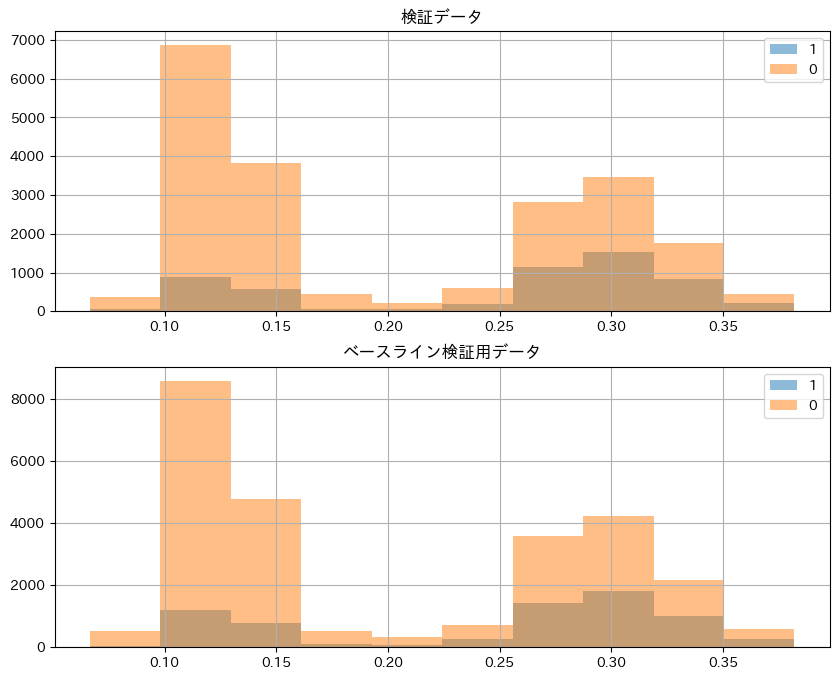

In [28]:
# 予測値の確率値算出
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

# 確率値をヒストグラムで可視化
fig = plt.figure(figsize=(10,8))
# 検証データ
fig.add_subplot(2,1,1)
plt.title("検証データ")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()
# ベースライン検証用データ
fig.add_subplot(2,1,2)
plt.title("ベースライン検証用データ")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()

# モデル推論
## 推論データセット作成
#### 推論用データセットの作成

In [29]:
df_test = pd.read_csv("Bank Churn/test.csv")
x_test = df_test[["IsActiveMember","EstimatedSalary"]]
id_test = df_test[["id"]]

In [30]:
x_test

,IsActiveMember,EstimatedSalary
0,1.0,160976.75
1,0.0,72549.27
2,0.0,138882.09
3,0.0,113931.57
4,0.0,139431.00
...,...,...
110018,1.0,148087.62
110019,1.0,42181.68
110020,0.0,16287.38
110021,1.0,158816.58


## 学習済モデルを用いた推論
#### 学習モデルによる推論

In [31]:
y_test_pred = model.predict_proba(x_test)

#### 提出用ファイルの作成

In [32]:
df_submit = pd.DataFrame({"id": id_test["id"], "Exited": y_test_pred[:, 1]})
display(df_submit.head(5))
df_submit.to_csv("submission_baseline.csv", index=None)
 

,id,Exited
0,165034,0.126898
1,165035,0.311304
2,165036,0.314091
3,165037,0.341760
4,165038,0.314091
